# Wisconsin Breast Cancer [Diagnosis]

## Modules

In [1]:
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
from neuralsens import partial_derivatives as ns
from joblib import dump

from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set()
set_config(display='diagram')

d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


torch installation could not be found, only numpy activation functions allowed


## Loading data

In [2]:
file_path = os.path.join(os.getcwd(), '../data/breast-cancer.csv')
df = pd.read_csv(file_path)
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

## EDA

In [3]:
print('Null values:', df.isnull().sum().sum())
print('NaN values:', df.isna().sum().sum())
print("Duplicates:", df.duplicated().sum())

Null values: 0
NaN values: 0
Duplicates: 0


Dataset seem to have no duplicates nor missing values, if there were any we would need to understand their origin identify them as MAR, MCAR or MNAR and decide if we want to discard them or retain them.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Let's use 'id' as index, we could also opt for dropping it uncommenting the first line and commenting the second one

In [5]:
# df.drop(['id'], axis=1, inplace=True) 
df = df.set_index('id')

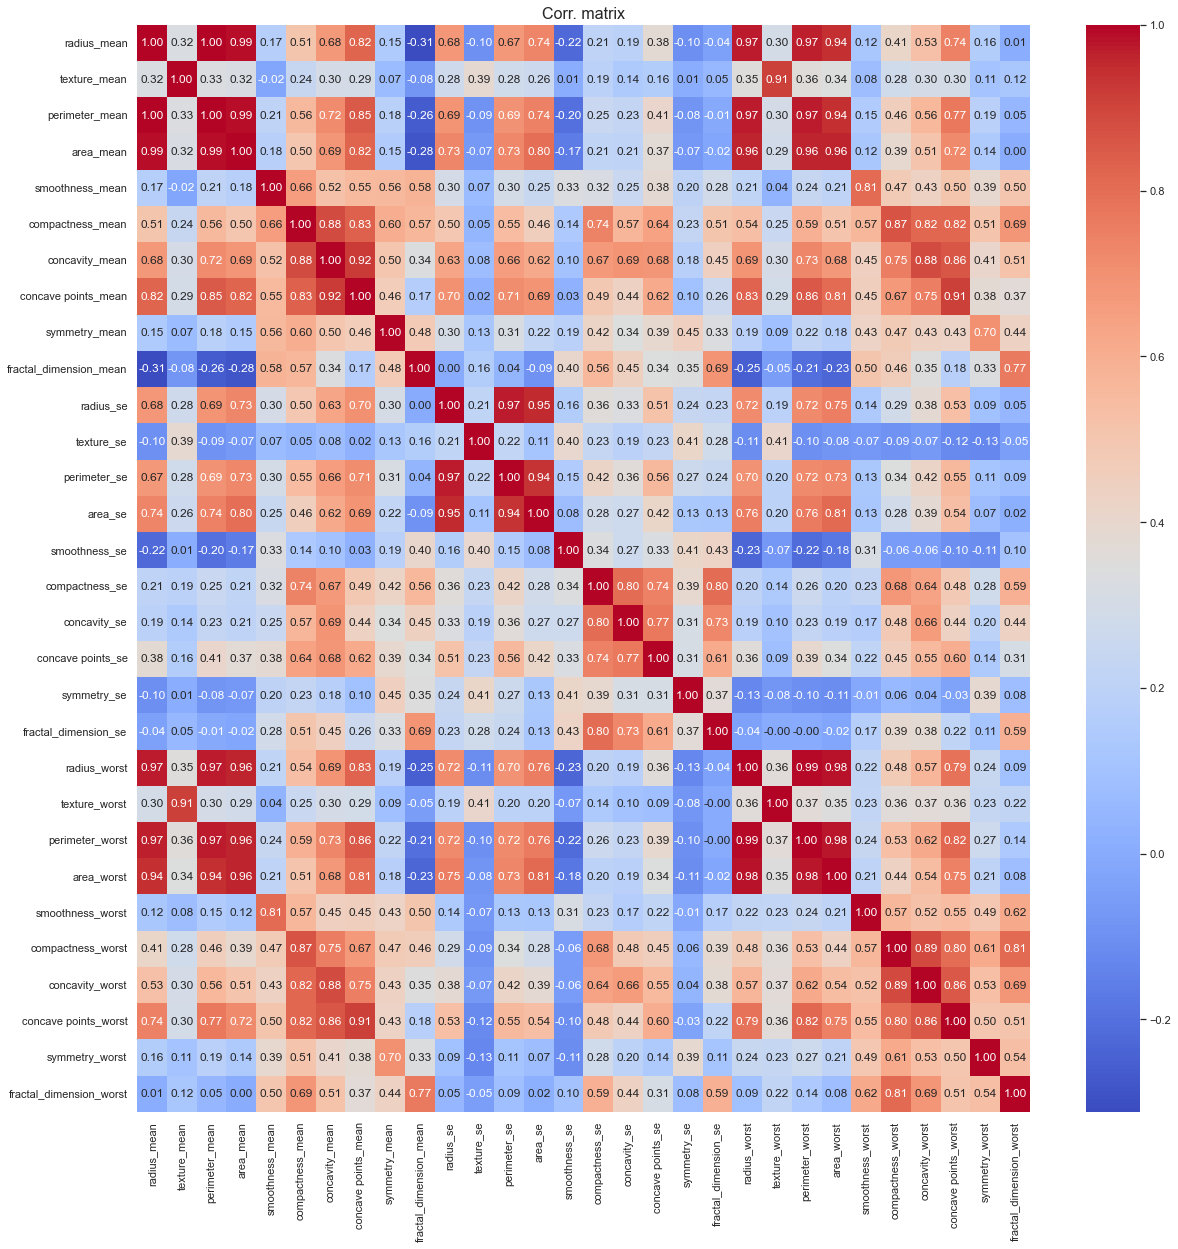

In [6]:
def corrMatrix(df:pd.DataFrame, title:None):
    plt.figure(figsize=(20,20))
    df_corr = df.select_dtypes(include=['int64','float64']).corr()
    sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title, fontsize=16)
    plt.show()

# We can see some highly correlated variables, some make sense due to their mathematical formulation or meaning: parameter-radius and area-radius or concave_points-concavity; 
# other might provide some insight: concave_points-radius

corrMatrix(df, 'Corr. matrix')

In [7]:
def calculateVIF(df:pd.DataFrame):
    df = df.select_dtypes(include=['int64','float64']) 

    df['intercept'] = 1

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['features'] = df.columns

    print(vif.round(1), '\n')

calculateVIF(df)

    VIF Factor                 features
0       3806.1              radius_mean
1         11.9             texture_mean
2       3786.4           perimeter_mean
3        347.9                area_mean
4          8.2          smoothness_mean
5         50.5         compactness_mean
6         70.8           concavity_mean
7         60.0      concave points_mean
8          4.2            symmetry_mean
9         15.8   fractal_dimension_mean
10        75.5                radius_se
11         4.2               texture_se
12        70.4             perimeter_se
13        41.2                  area_se
14         4.0            smoothness_se
15        15.4           compactness_se
16        15.7             concavity_se
17        11.5        concave points_se
18         5.2              symmetry_se
19         9.7     fractal_dimension_se
20       799.1             radius_worst
21        18.6            texture_worst
22       405.0          perimeter_worst
23       337.2               area_worst


In [8]:
df.describe().round(2)

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
count       569.00        569.00          569.00     569.00           569.00   
mean         14.13         19.29           91.97     654.89             0.10   
std           3.52          4.30           24.30     351.91             0.01   
min           6.98          9.71           43.79     143.50             0.05   
25%          11.70         16.17           75.17     420.30             0.09   
50%          13.37         18.84           86.24     551.10             0.10   
75%          15.78         21.80          104.10     782.70             0.11   
max          28.11         39.28          188.50    2501.00             0.16   

       compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
count            569.00          569.00               569.00         569.00   
mean               0.10            0.09                 0.05           0.18   
std                0.05            0.08                 0.04           0.03   
min                0.02            0.00                 0.00           0.11   
25%                0.06            0.03                 0.02           0.16   
50%                0.09            0.06                 0.03           0.18   
75%                0.13            0.13                 0.07           0.20   
max                0.35            0.43                 0.20           0.30   

       fractal_dimension_mean  ...  radius_worst  texture_worst  \
count                  569.00  ...        569.00         569.00   
mean                     0.06  ...         16.27          25.68   
std                      0.01  ...          4.83           6.15   
min                      0.05  ...          7.93          12.02   
25%                      0.06  ...         13.01          21.08   
50%                      0.06  ...         14.97          25.41   
75%                      0.07  ...         18.79          29.72   
max                      0.10  ...         36.04          49.54   

       perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
count           569.00      569.00            569.00             569.00   
mean            107.26      880.58              0.13               0.25   
std              33.60      569.36              0.02               0.16   
min              50.41      185.20              0.07               0.03   
25%              84.11      515.30              0.12               0.15   
50%              97.66      686.50              0.13               0.21   
75%             125.40     1084.00              0.15               0.34   
max             251.20     4254.00              0.22               1.06   

       concavity_worst  concave points_worst  symmetry_worst  \
count           569.00                569.00          569.00   
mean              0.27                  0.11            0.29   
std               0.21                  0.07            0.06   
min               0.00                  0.00            0.16   
25%               0.11                  0.06            0.25   
50%               0.23                  0.10            0.28   
75%               0.38                  0.16            0.32   
max               1.25                  0.29            0.66   

       fractal_dimension_worst  
count                   569.00  
mean                      0.08  
std                       0.02  
min                       0.06  
25%                       0.07  
50%                       0.08  
75%                       0.09  
max                       0.21  

[8 rows x 30 columns]

To ease visualization, understand better how each measure contributes to the diagnosis, compare and contrast, we are going to analyze them separately dividing the dataframe in three. Besides since the measures are over the same feature we will reduce multicolinearity and facilitate interpretation

In [9]:
# Separamos cada feature en sus tres medidas
df_mean = df[df.columns[:11]]
df_se = df.drop(df.columns[1:11], axis=1).drop(df.columns[21:], axis=1)
df_worst = df.drop(df.columns[1:21], axis=1)

We can observe almost perfecly linear patterns in some of the features, specifically in the three we mentioned before, which seems to veify our multicolinearity assumption but we will ascertain it more with a last test further below. Moving forward as we discussed we will use dimensionality reduction and given the linearity of the variables we will attempt PCA. </br>
We can also observe what could look like multivariate outliers in plots like perimeter_se-texture_se, we will take a closer look to some of these later although most can be observed in the pairplots. </br>
A few features like area_mean and fractal_dimension_mean seem negatively correlated </br>

Text(0.5, 0.98, 'Mean features pairplot')

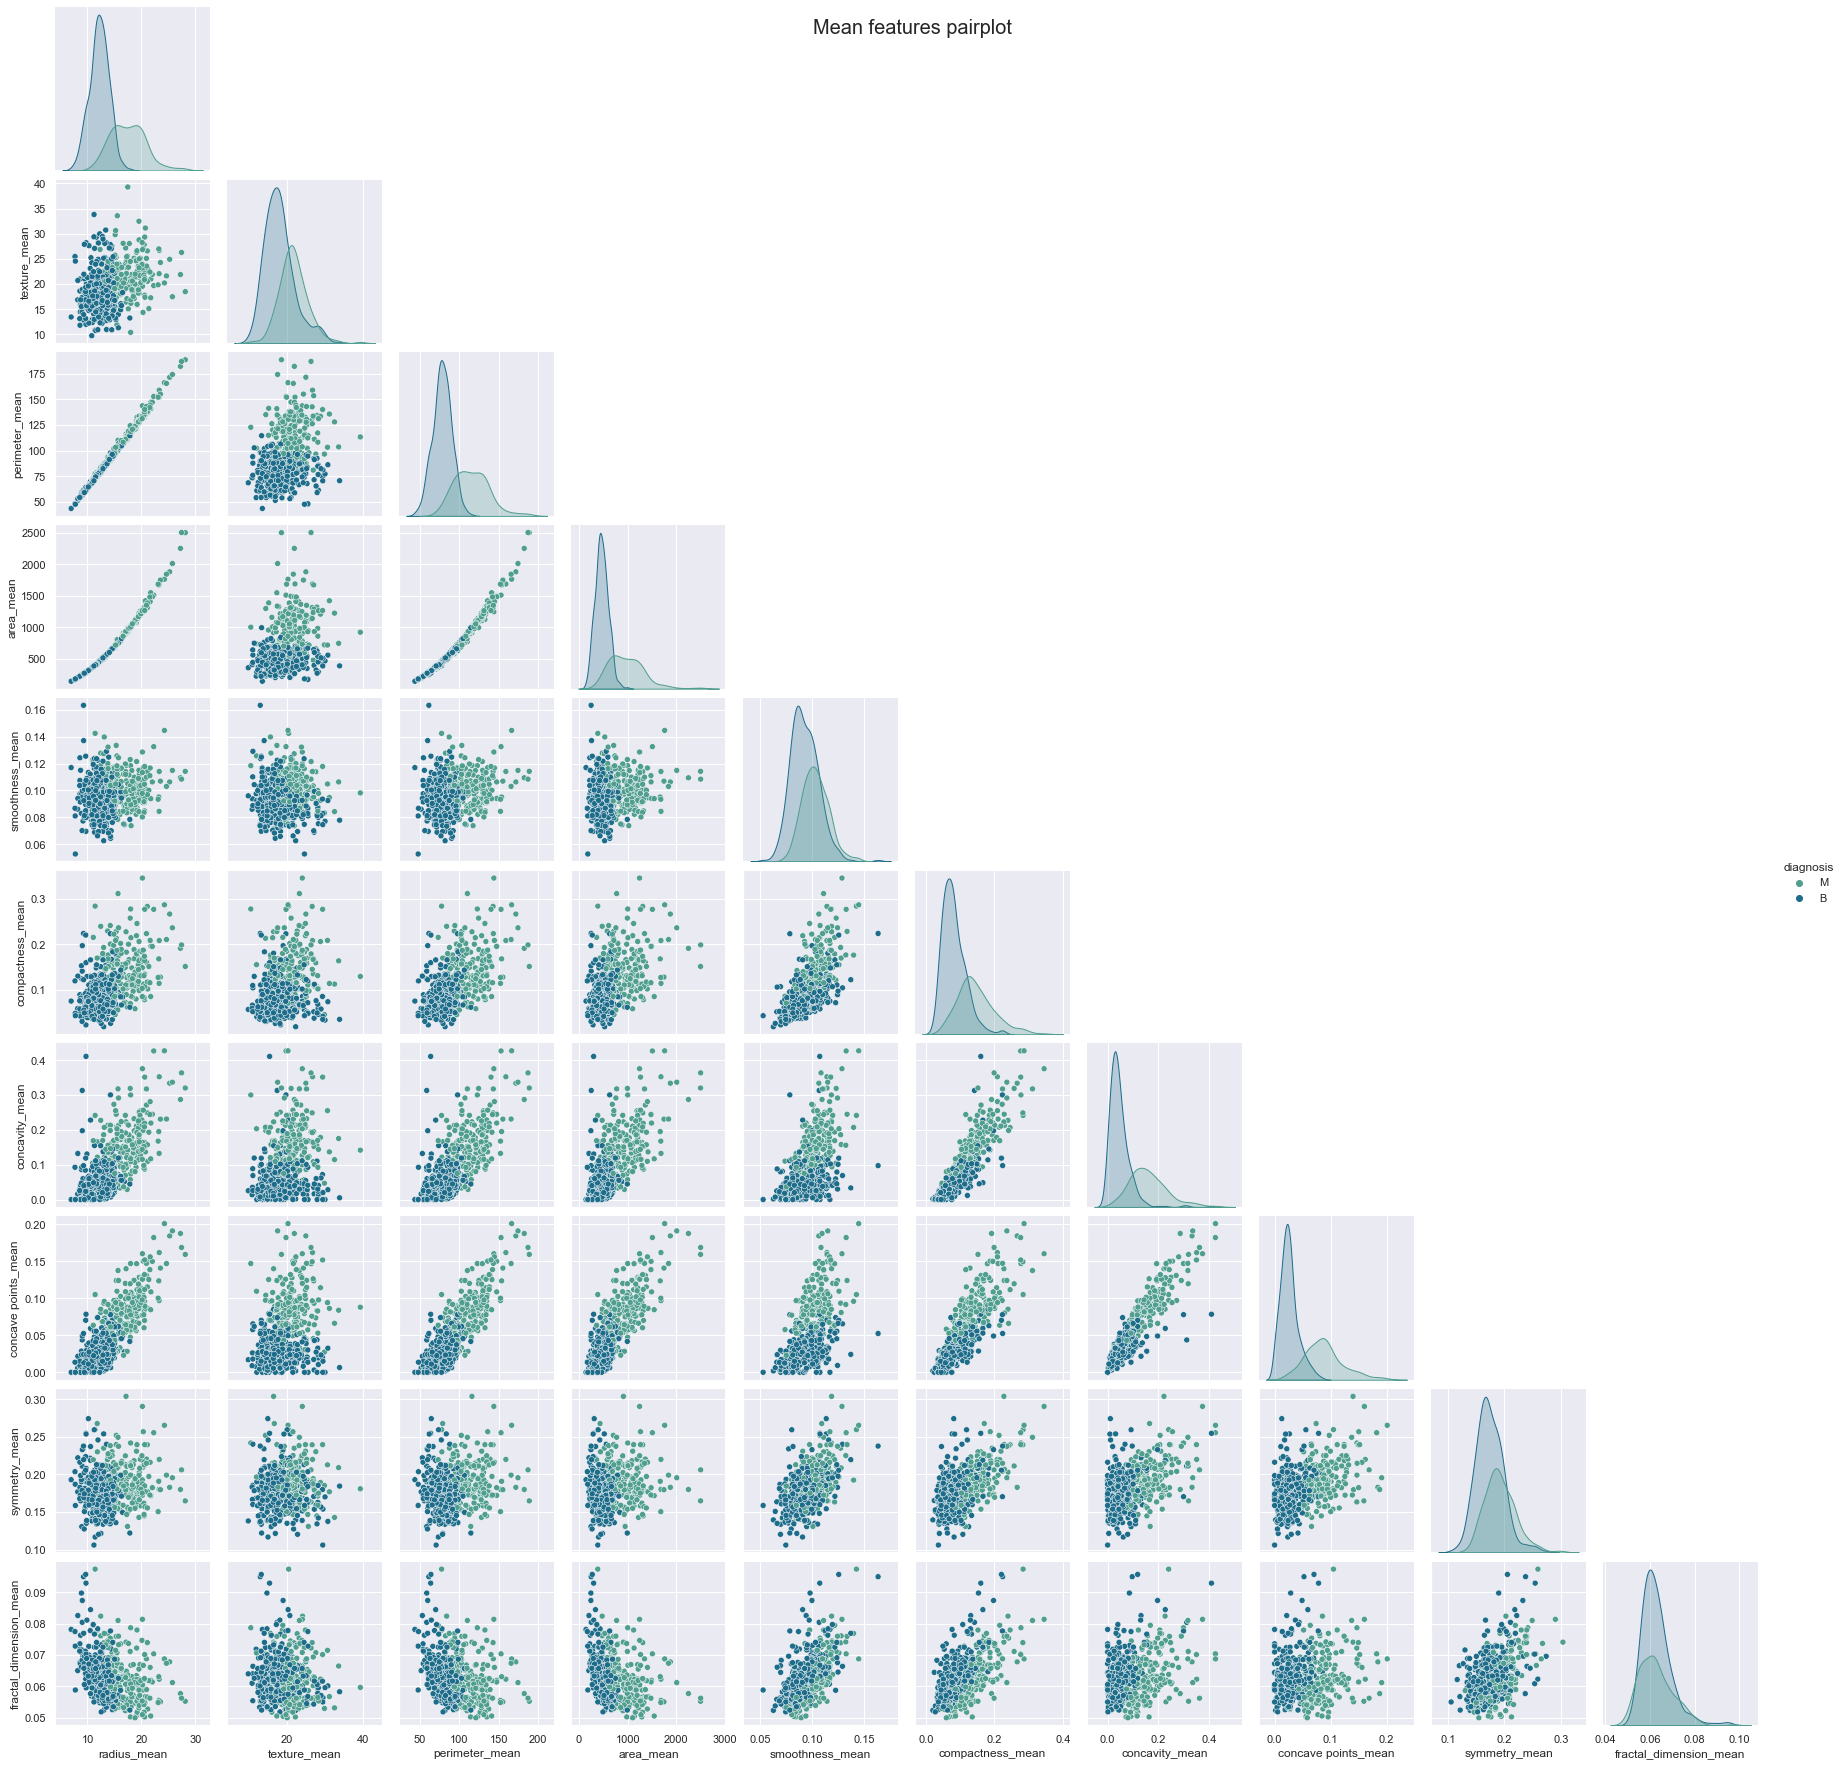

In [10]:
sns.pairplot(data=df_mean, hue='diagnosis', palette='crest', corner=True).fig.suptitle('Mean features pairplot', fontsize = 20)

Text(0.5, 0.98, 'Worst features pairplot')

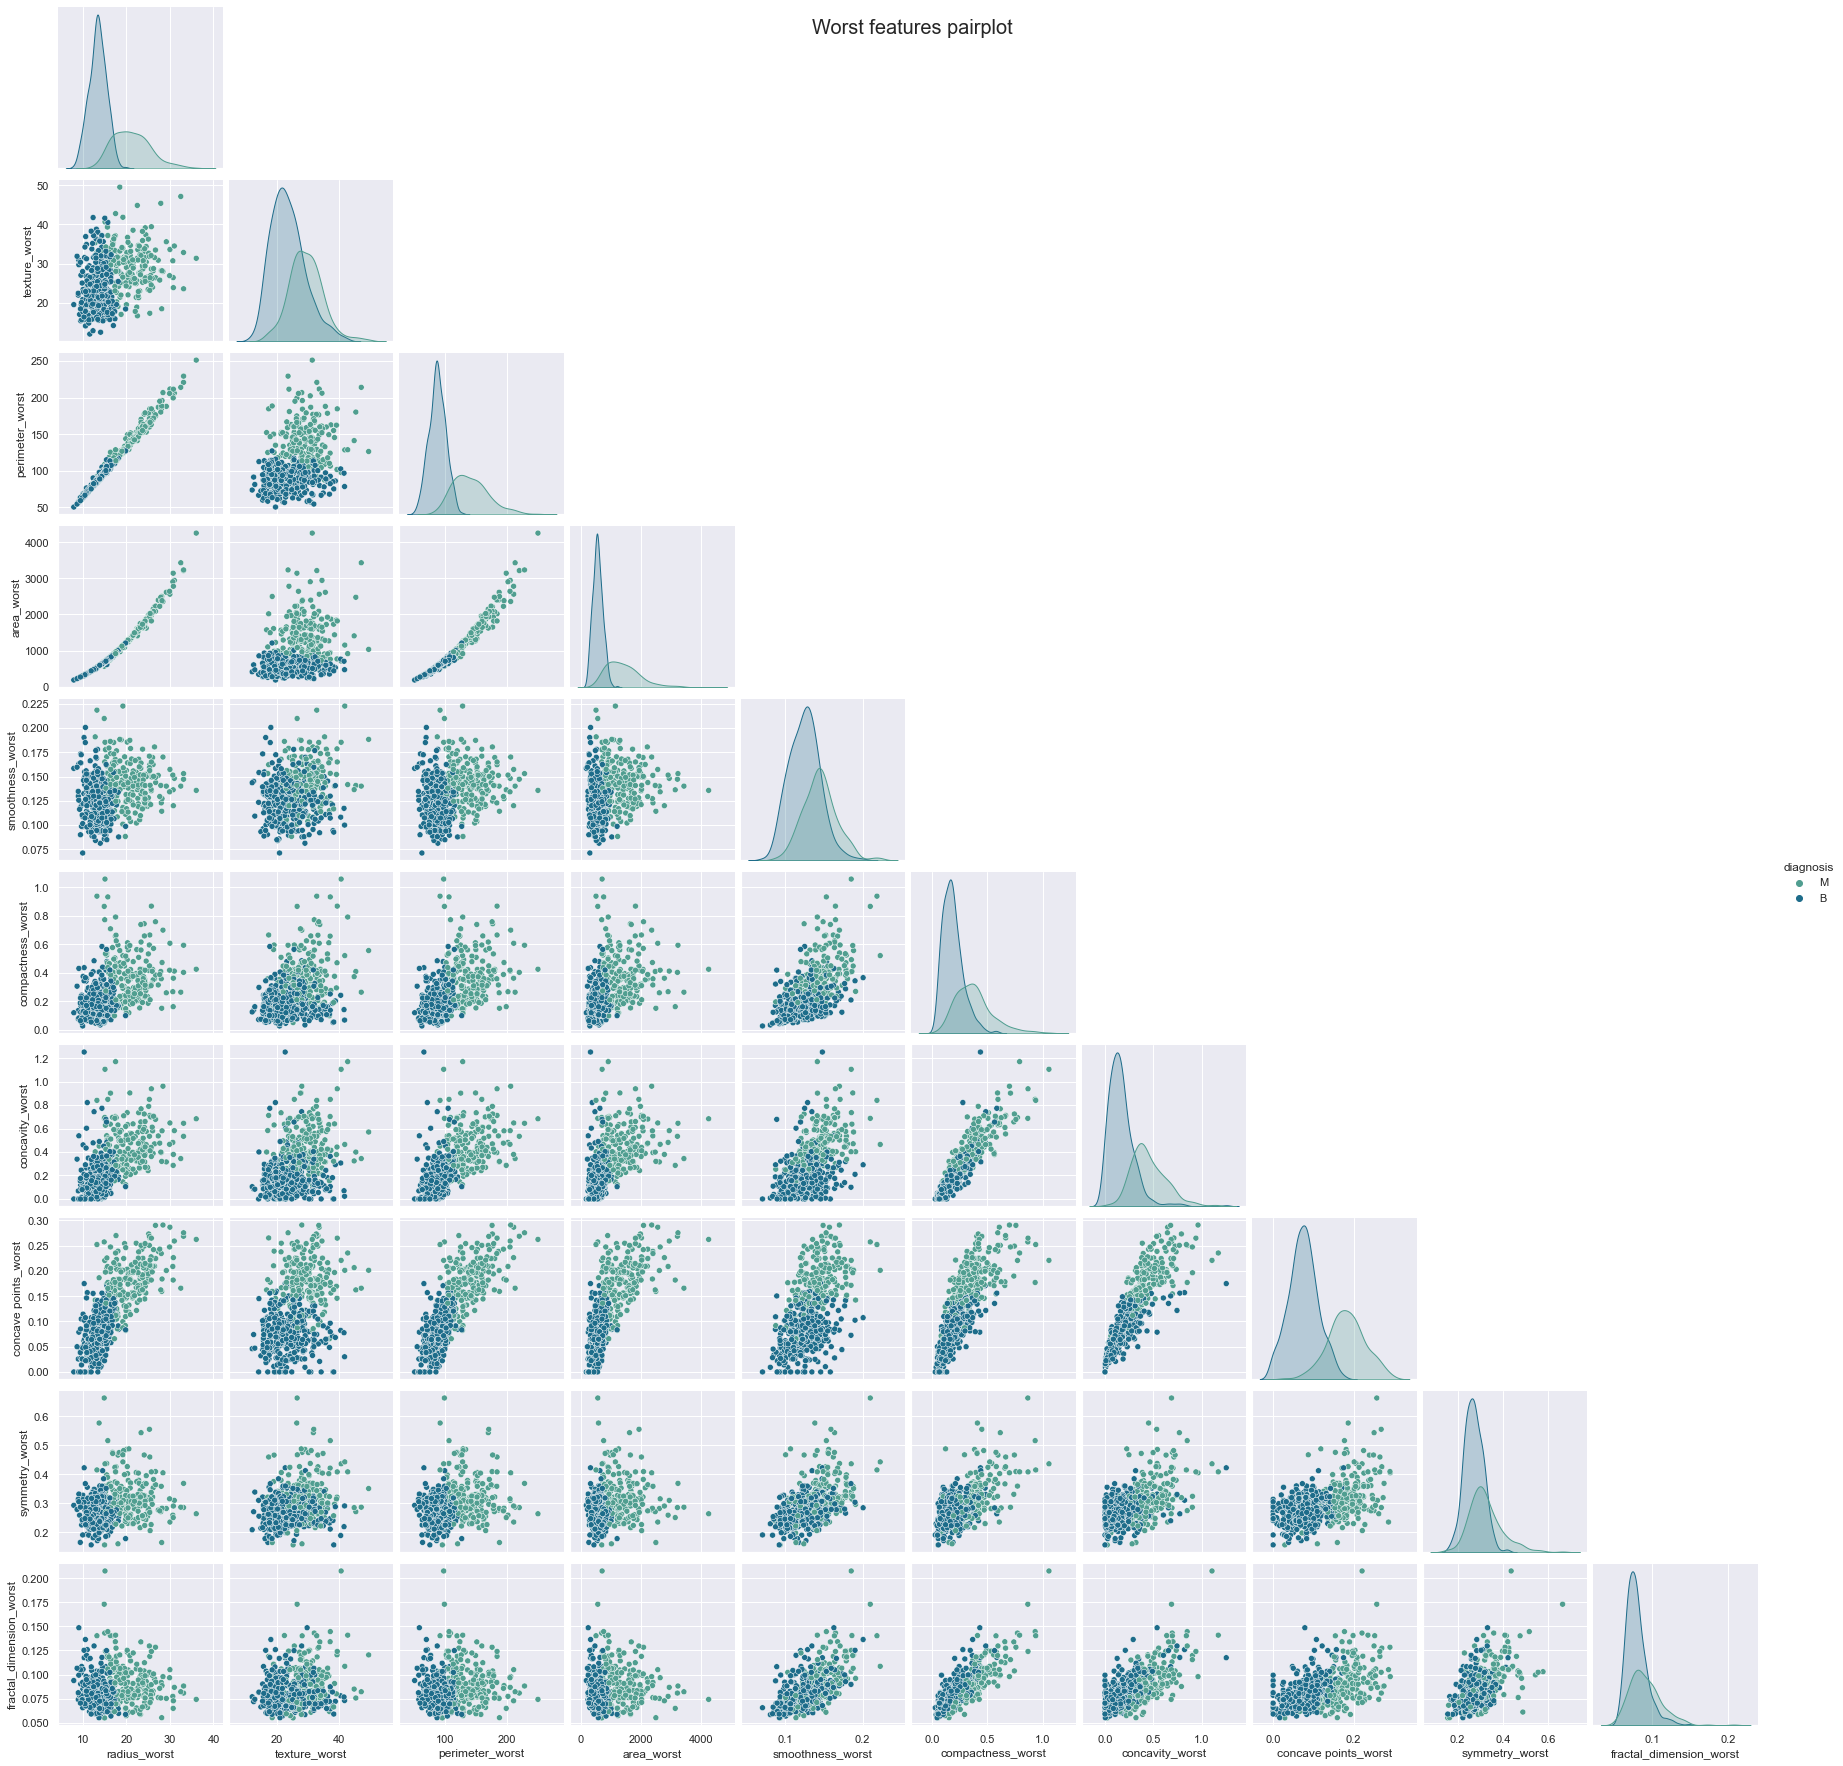

In [11]:
sns.pairplot(data=df_worst, hue='diagnosis', palette='crest', corner=True).fig.suptitle('Worst features pairplot', fontsize = 20)

Text(0.5, 0.98, 'Standard Error features pairplot')

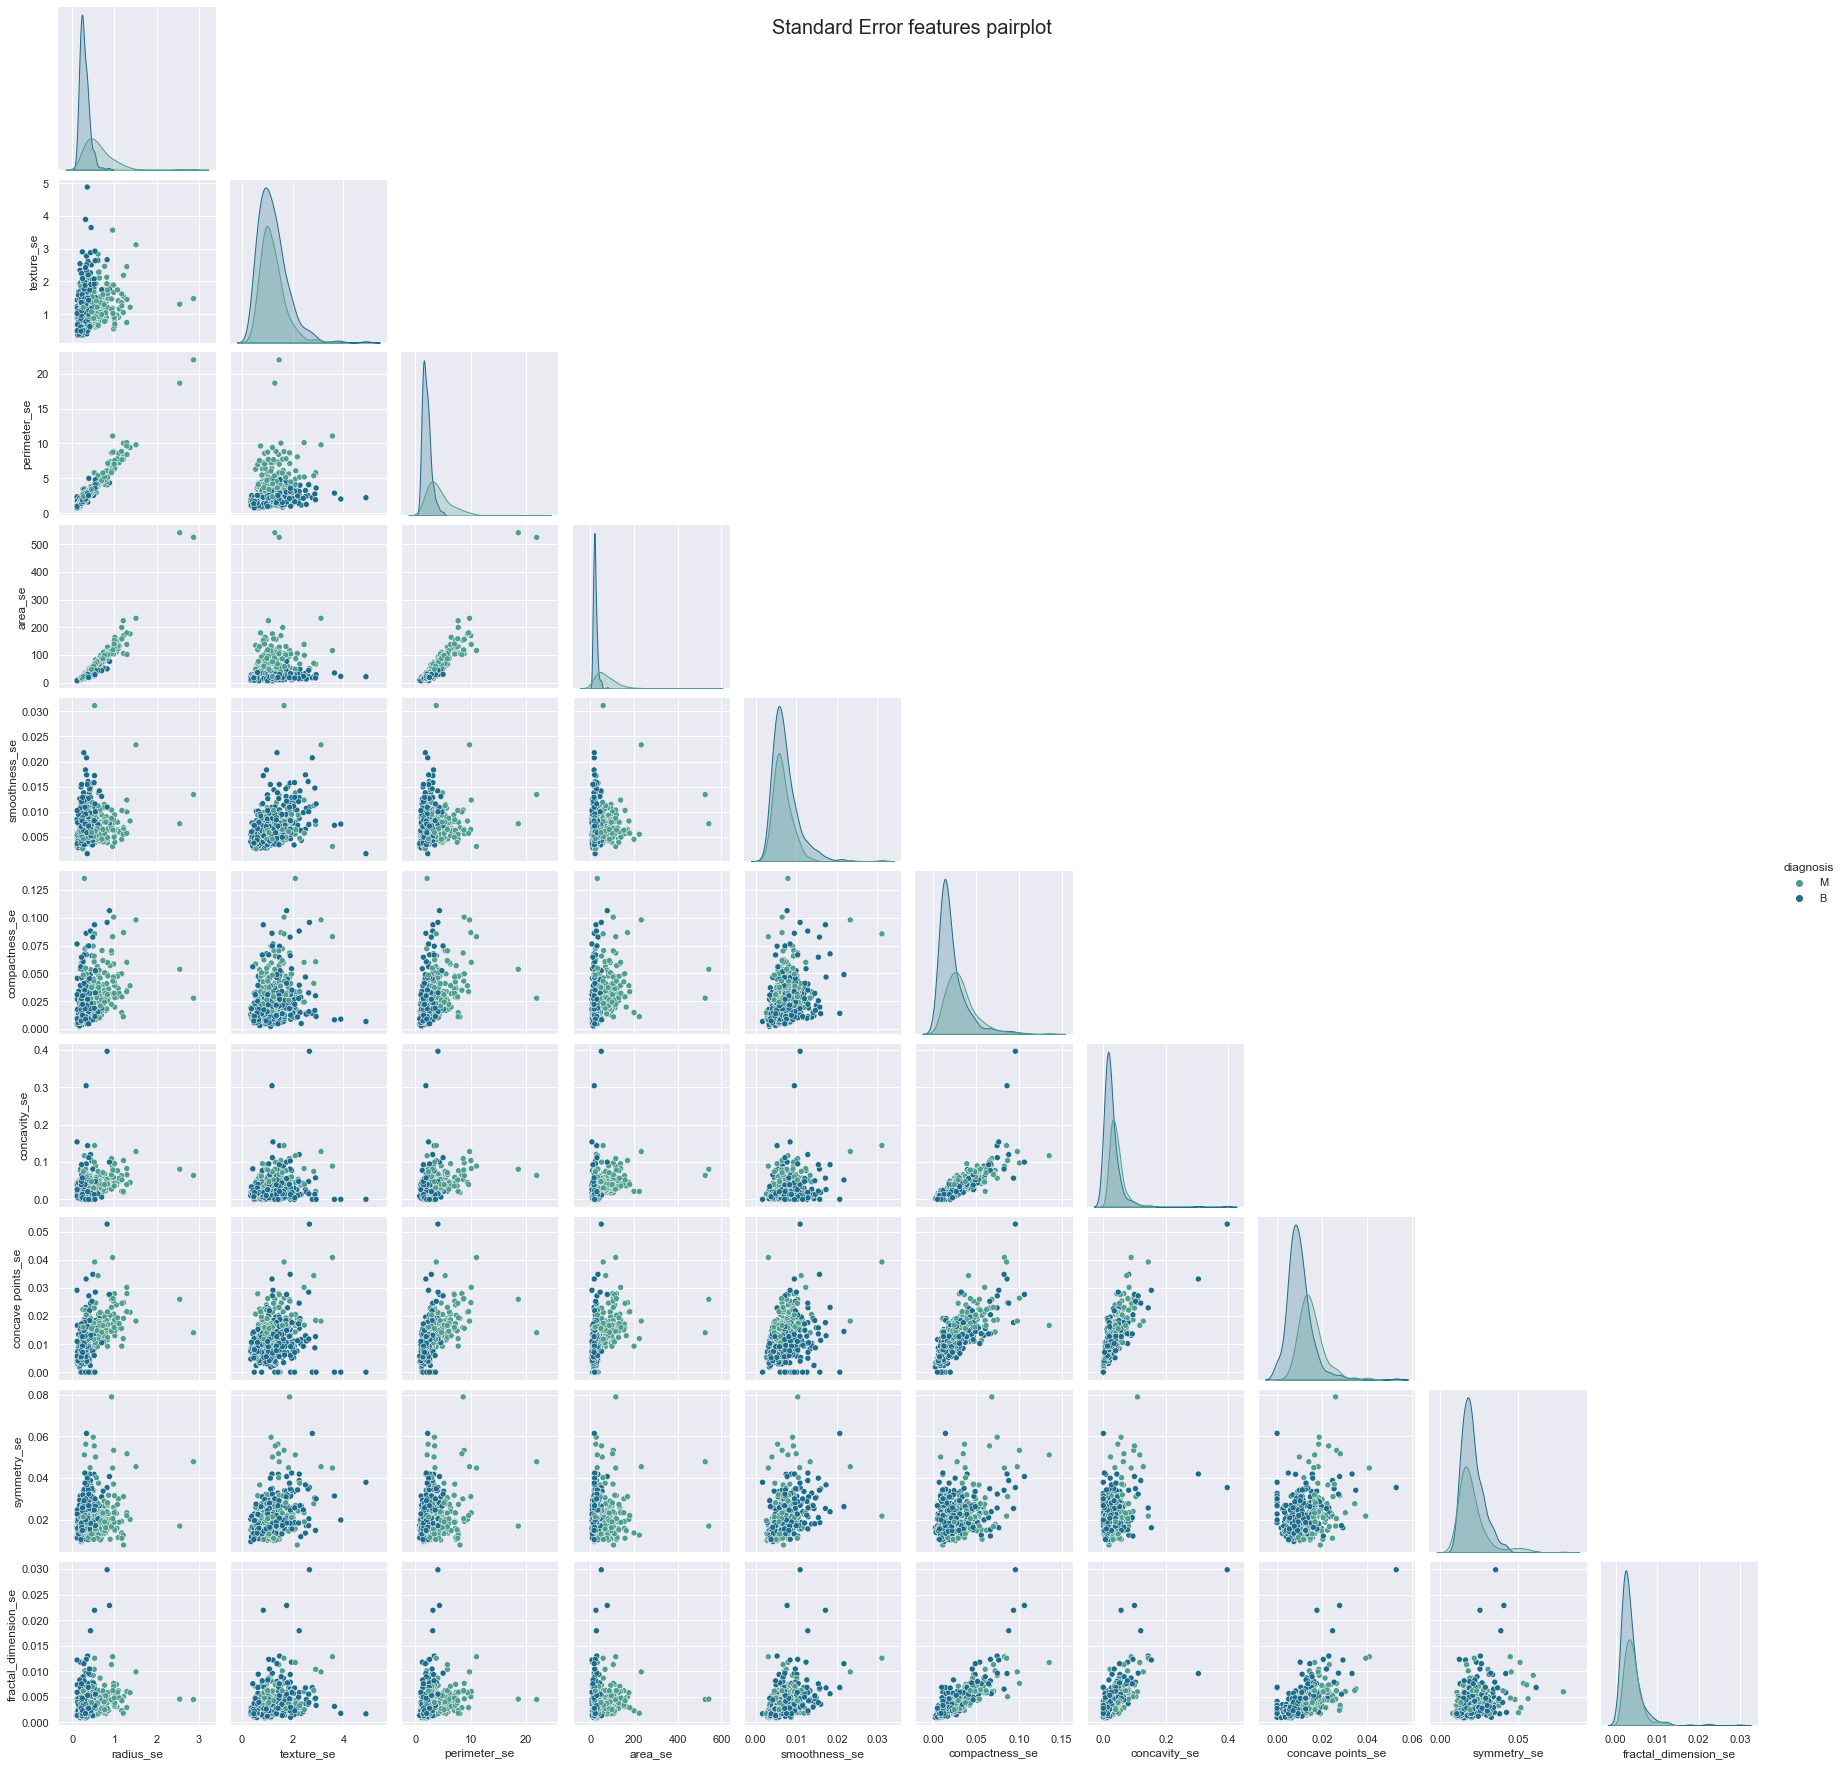

In [12]:
sns.pairplot(data=df_se, hue='diagnosis', palette='crest', corner=True).fig.suptitle('Standard Error features pairplot', fontsize = 20)

Variables like radius_mean, perimeter_mean, area_mean or concave_points_mean seem to have a strong correlation over the output,
others like symmetry_mean or fractal_dimension_mean not as much.

<AxesSubplot:title={'center':'Correlation of Features with Diagnosis'}>

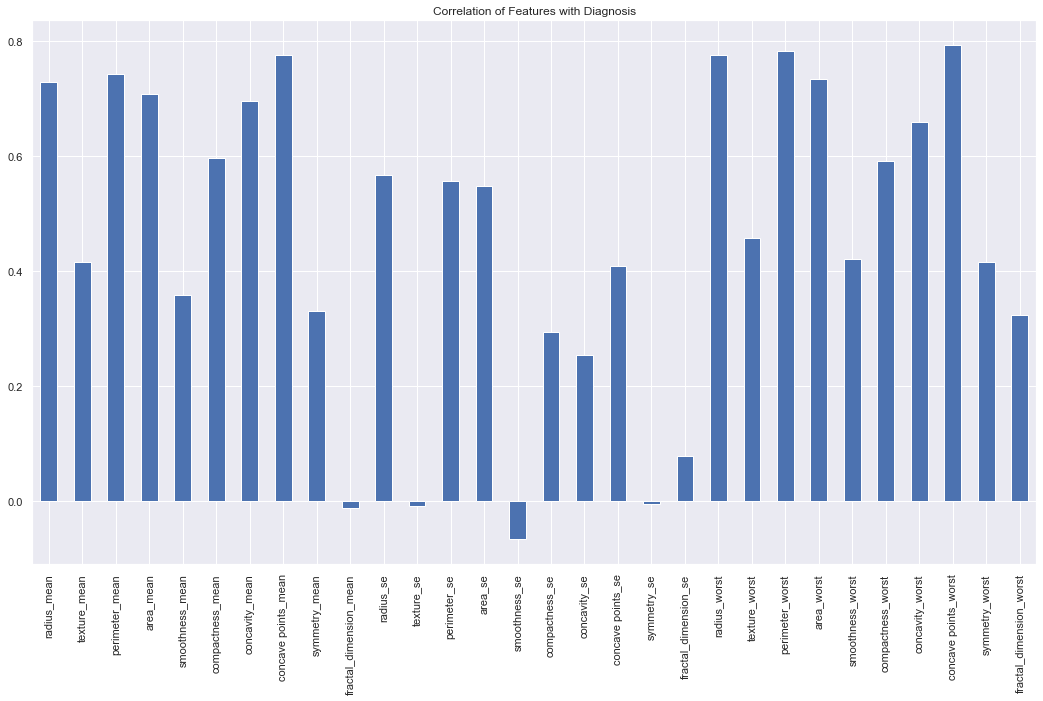

In [ ]:
plt.figure(figsize=(18,10))
df.drop('diagnosis', axis=1).corrwith(df.diagnosis).plot(kind='bar', grid=True, title="Correlation of Features with Diagnosis")

## Data Preprocessing

In [13]:
d = df['diagnosis'].unique()
print("Diagnosis labels:", d)

Diagnosis labels: ['M' 'B']


In [14]:
# We encode target variable as category and encode its label
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'].astype('category'))
# After fitting the LabelEncoder
print("Encoded classes:", le.classes_)

Encoded classes: ['B' 'M']


In [15]:
# Separamos cada feature en sus tres medidas
df_mean = df[df.columns[:11]]
df_se = df.drop(df.columns[1:11], axis=1).drop(df.columns[21:], axis=1)
df_worst = df.drop(df.columns[1:21], axis=1)

We are going to assume that the data was measured correctly and therefore the outliers provide useful information about the variables variance given one individual is different to other, this way we keep the most data.

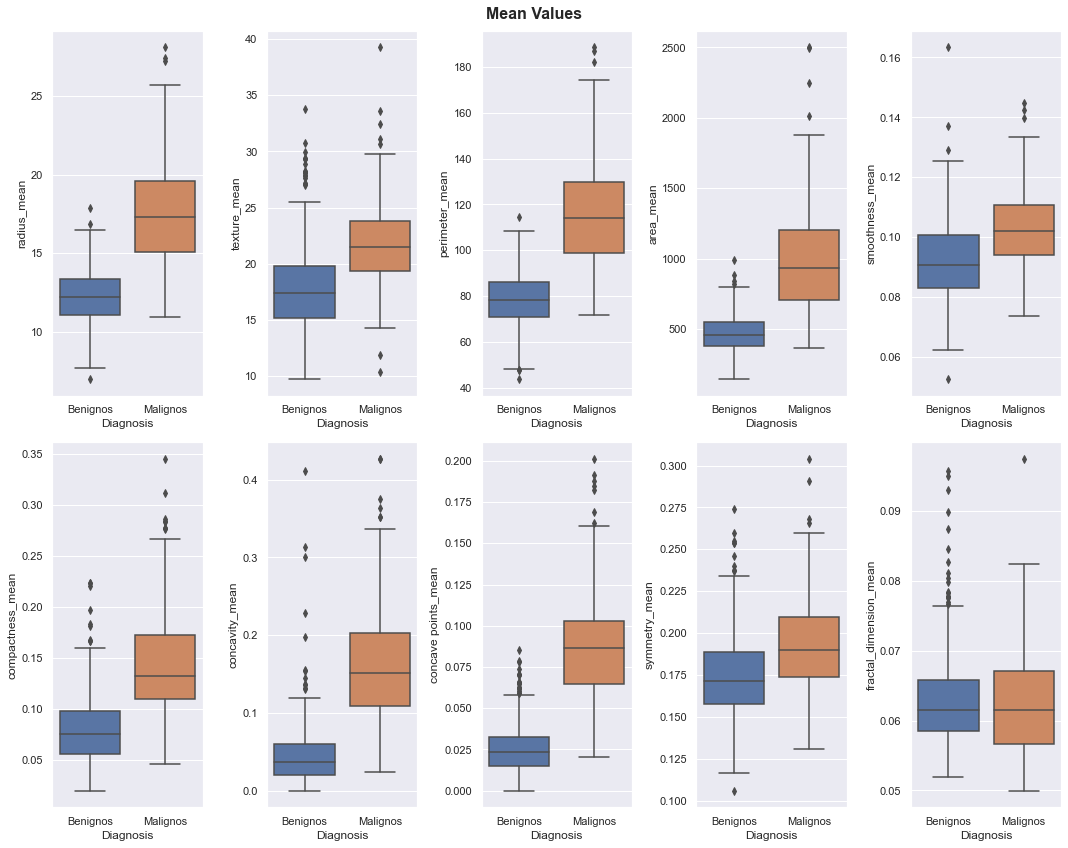

In [18]:
def boxPlot(df:pd.DataFrame, title:str=None, y:str='diagnosis', ncols:int=None, nrows:int=None)->tuple[plt.Figure, np.ndarray]:
    '''
    Print boxplots against target variable, assumes target variable is included in the dataframe.
    Plots by default in a 2x5 grid

    params:
        - df: Dataframe containing the data to plot
        - title: title
        - y: target variable
        - ncols: num cols in plot
        - nrows: num of rows in plot
    '''
    columns = df.columns.tolist()
    columns.remove(y)

    if (ncols is None) and (nrows is None):
        ncols = (len(columns)-1) // 2 +1
        nrows = 2
    elif ncols is None:
        ncols = (len(columns)-1) // nrows + 1
    elif nrows is None:
        nrows = len(columns) // ncols + 1 

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))


    for i, col_name in enumerate(columns):
        row = i // ncols 
        col = i % ncols

        ax = axes[row, col]

        sns.boxplot(x='diagnosis', y=col_name, data=df, ax=ax)
        ax.set_xticklabels(['Benignos', 'Malignos']) 
        ax.set_xlabel('Diagnosis')
        ax.set_ylabel(col_name)

    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Variables como radius_mean, perimeter_mean, area_mean o concave_points_mean parecen tener un efecto notable sobre la salida
# otras como symmetry_mean o fractal_dimension_mean no tanto a primera vista

boxPlot(df_mean, 'Mean Values')

Variables like radius_se, perimeter_se or area_se seem to have a strong effect over the output,
others like texture_se, smoothness_se or symmetry_se not as much.

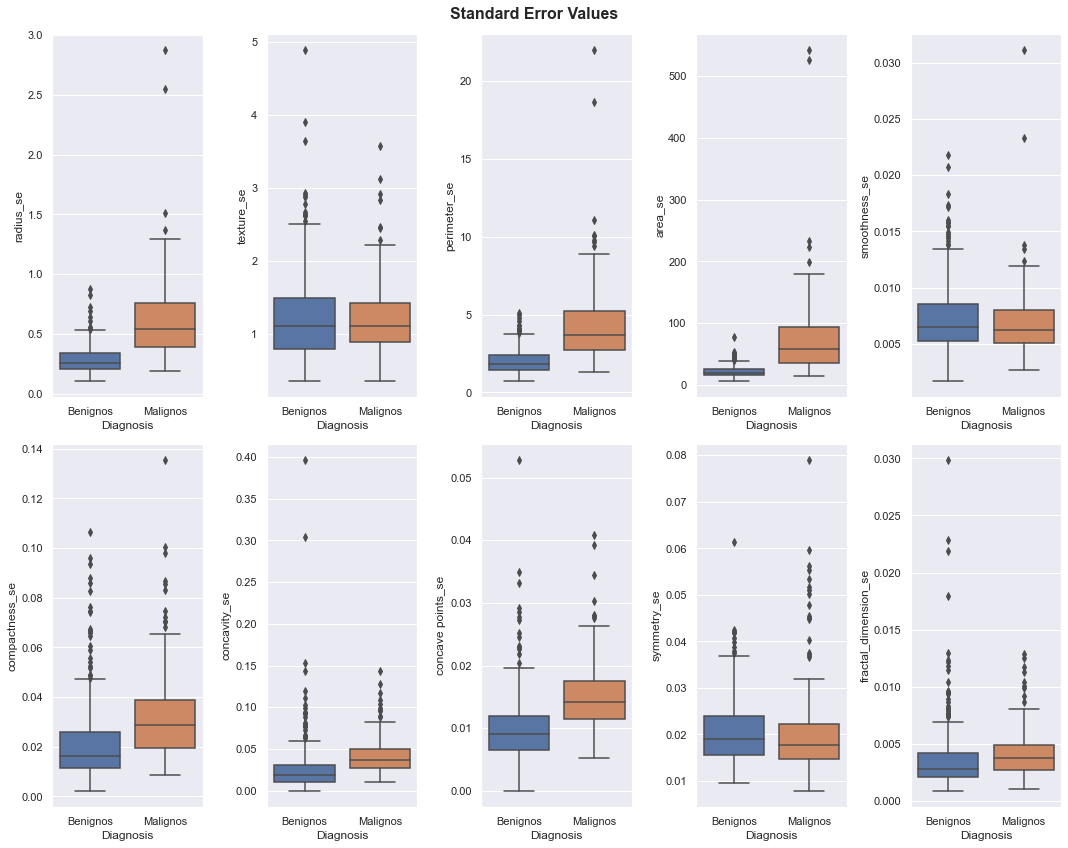

In [19]:
# Variables como radius_se, perimeter_se o area_se parecen tener un efecto notable sobre la salida
# otras como texture_se, smoothness_se o symmetry_se no tanto a primera vista

boxPlot(df_se, 'Standard Error Values')

Variables like radius_worst, perimeter_worst, area_worst or concave_points_worst parecen seem to have a strong effect over the output,
others like symmetry_worst or fractal_dimension_worst not as much.

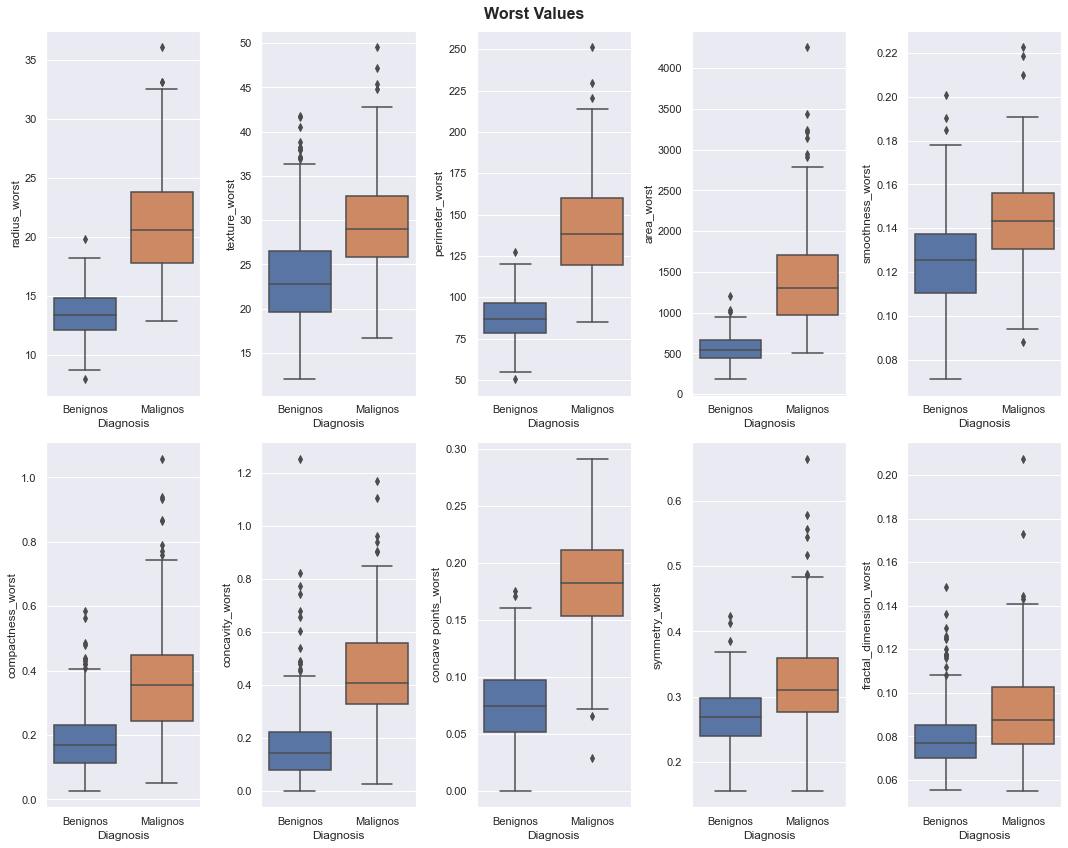

In [131]:
# Variables como radius_mean, perimeter_mean, area_mean o concave_points_mean parecen tener un efecto notable sobre la salida
# otras como symmetry_mean o fractal_dimension_mean no tanto a primera vista

# Podemos observar en esta ultima como en la anteriores la presencia de outliers univariantes
# Mas adelante se barajara su estudio y eliminación
boxPlot(df_worst, 'Worst Values')

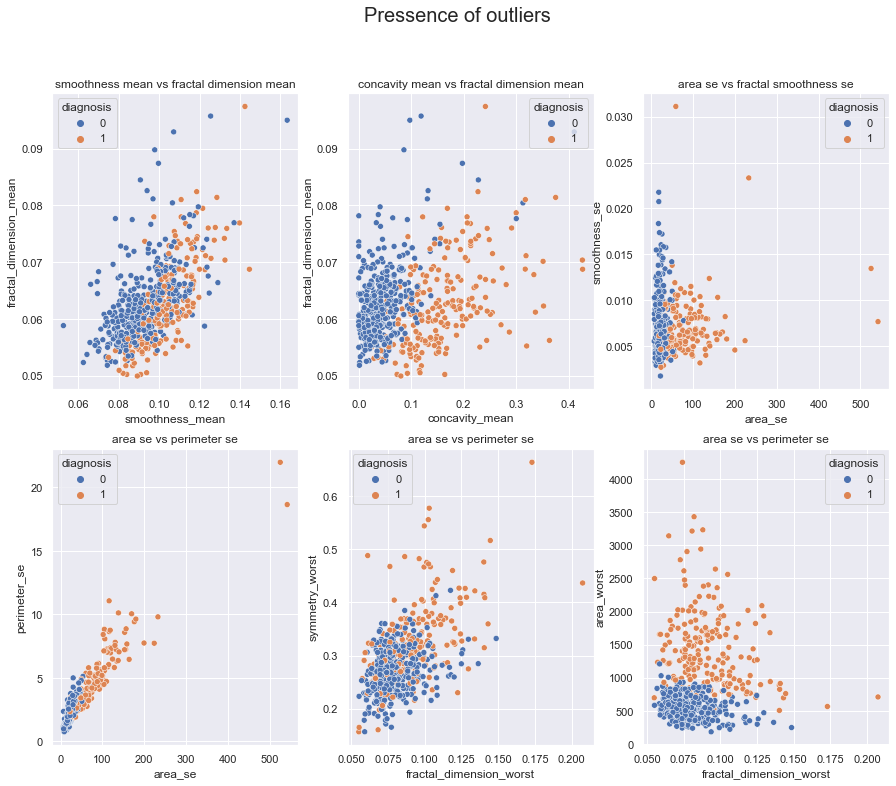

In [ ]:
fig = plt.figure(figsize=(15,12))

plt.subplot(231)
ax1 = sns.scatterplot(x = df_mean['smoothness_mean'], y = df_mean['fractal_dimension_mean'], hue = "diagnosis", data = df_mean)
plt.title('smoothness mean vs fractal dimension mean')

plt.subplot(232)
ax2 = sns.scatterplot(x = df_mean['concavity_mean'], y = df_mean['fractal_dimension_mean'], hue = "diagnosis", data = df_mean)
plt.title('concavity mean vs fractal dimension mean')

plt.subplot(233)
ax2 = sns.scatterplot(x = df_se['area_se'], y = df_se['smoothness_se'], hue = "diagnosis",data = df_se)
plt.title('area se vs fractal smoothness se')

plt.subplot(234)
ax2 = sns.scatterplot(x = df_se['area_se'], y = df_se['perimeter_se'], hue = "diagnosis",data = df_se)
plt.title('area se vs perimeter se')

plt.subplot(235)
ax2 = sns.scatterplot(x = df_worst['fractal_dimension_worst'], y = df_worst['symmetry_worst'], hue = "diagnosis",data = df_worst)
plt.title('area se vs perimeter se')

plt.subplot(236)
ax2 = sns.scatterplot(x = df_worst['fractal_dimension_worst'], y = df_worst['area_worst'], hue = "diagnosis",data = df_worst)
plt.title('area se vs perimeter se')

fig.suptitle('Pressence of outliers', fontsize = 20)
plt.show()

Given that the imbalance is not too exaggerated and to avoid the risk of ovefitting the model we are going to put off resampling with a technique like ROSE and just apply stratification when splitting the data.

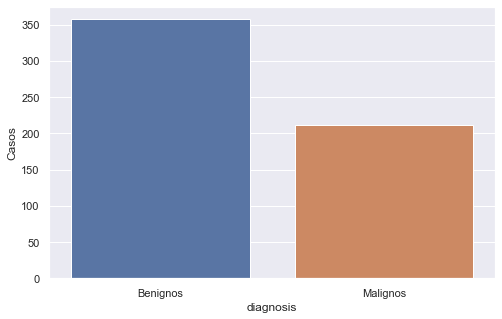

Benign Cases: 357
Malign Cases: 212


In [ ]:
# Estamos ante un dataset desbalanceado

plt.figure(figsize=(8,5))
ax = sns.countplot(x='diagnosis', data=df)
ax.set_ylabel("Casos")
plt.xticks([0, 1], ['Benignos', 'Malignos']) 
plt.show()

B, M = df['diagnosis'].value_counts()
print('Benign Cases:', B)
print('Malign Cases:', M)

## Feature Selection

Lets train our L1 model to perform feature selection

In [67]:
from sklearn.pipeline import make_pipeline

# Train test split: lets do a baseline model with all variables
INPUTS = df.columns[1:].tolist()
OUTPUT = 'diagnosis'

X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)  # Stratify to keep class proportion in both train and test

# Create a pipeline with Lasso regularization
lasso_model = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear'))

# Define a range of C values
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

coefs = []
f1_scores = []

# Loop over different C values and fit the model
for C in C_values:
    lasso_model.named_steps['logisticregression'].set_params(C=C)
    lasso_model.fit(X_train, y_train)
    coefs.append(lasso_model.named_steps['logisticregression'].coef_[0])
    
    # Predict on test set and calculate F1 score
    y_pred = lasso_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

    #print('Model Trained\tF1 score:', f1)

# Convert coefs to numpy array for plotting
coefs = np.array(coefs)

# Transpose the coefs array for correct dimensions
coefs = coefs.T

print('Training Finished')

Training Finished


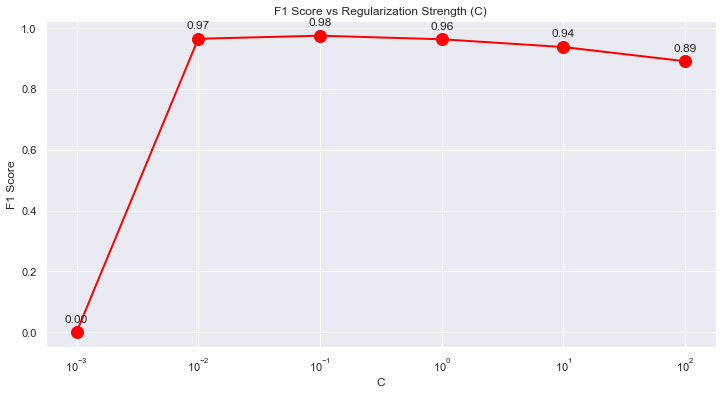

In [38]:
# Increase dot size and add connecting lines
plt.figure(figsize=(12, 6))
plt.plot(C_values, f1_scores, marker='o', linestyle='-', color='red', linewidth=2, markersize=12)
plt.grid()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Regularization Strength (C)')

# Annotate data points with F1 scores
for c, f1 in zip(C_values, f1_scores):
    plt.annotate(f'{f1:.2f}', (c, f1), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid()
plt.show()

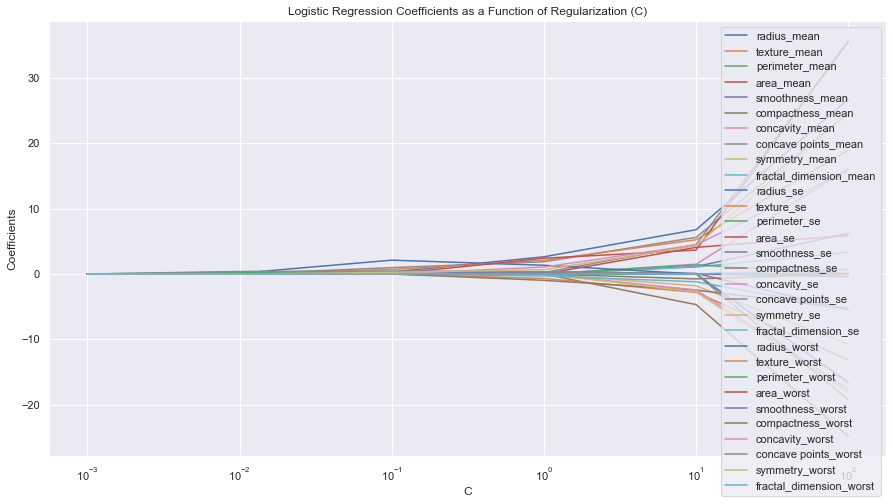

In [39]:
# Plot evolution of coefficients with different values of C
# Increase figure size
plt.figure(figsize=(15, 8))
ax = plt.gca()
ax.plot(C_values, coefs.T)
ax.set_xscale('log')
plt.xlabel('C')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Coefficients as a Function of Regularization (C)')
plt.legend(X_train.columns)  # If you have 5 features, adjust accordingly
plt.axis('tight')
plt.show()

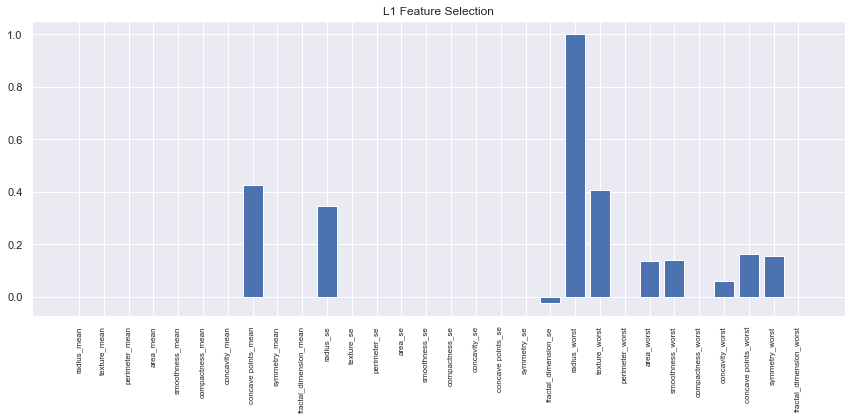

In [145]:
# Create a pipeline with Lasso regularization
lasso_model = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear', C=0.2))
lasso_model.fit(X_train, y_train)

# Get the real feature names from the original dataframe
real_features = X_train.columns

# Get the normalized coefficients from the lasso_model
norm_coefs = (lasso_model.named_steps['logisticregression'].coef_)[0] / np.max(np.abs(lasso_model.named_steps['logisticregression'].coef_))

# Plot the bar chart
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.bar(real_features, norm_coefs)
ax.set_xticks(range(len(real_features)))
ax.set_xticklabels(labels=real_features, rotation=90, fontsize=8)
plt.title('L1 Feature Selection')
plt.tight_layout()
plt.show()

In [112]:
from sklearn.feature_selection import SelectFromModel
selected_features = SelectFromModel(lasso_model.named_steps['logisticregression'], prefit=True, threshold=0.15)
print('Selected Features:\n', selected_features.get_feature_names_out(input_features=X_train.columns))
X_train_selected = selected_features.transform(X_train)
X_test_selected = selected_features.transform(X_test)

Selected Features:
 ['concave points_mean' 'radius_se' 'radius_worst' 'texture_worst'
 'area_worst' 'smoothness_worst' 'concave points_worst' 'symmetry_worst']


d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## Training

Since we are dealing with human lives here, we are going to have two scenarios:

1.- In this first one, we are going to assume that diagnosing a patient's cell as malign when they ae benign carries severe consequences in the patient's life, albeit because of the implications of the following treatment. For this case we are going to want to be right all the time we diagnose a patient with malign cells, for that a sound metric for success to use would be Precision.

2.- In this second one, we are going to assume that once we classify a cell as malign, further medical test will be carried out to verify that is the case. With that assumption in mind our worst case scenario will be missclassifying a malign cell such causing the release of a potetentially ill person. Given this reasoning I belive a sound metric for success to use is Recall. 

Given these two scenarios and with the idea in mind of having to choose one model only, we are going to opt for f1-score as our metric to try and maximize both scenarios.

Below we are going to define some helper functions:

In [68]:
def display_metrics(true_labels, predicted_labels, positive_label, negative_label, model):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=[positive_label, negative_label])

    # Calculate various metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, pos_label=positive_label)
    precision = precision_score(true_labels, predicted_labels, pos_label=positive_label)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, pos_label=positive_label)

    # Display confusion matrix
    plt.figure(figsize=(15,12))
    ConfusionMatrixDisplay(cm, display_labels=[positive_label, negative_label]).plot(values_format='.0f')
    plt.show()

    # Print metrics
    print(f'Accuracy: {accuracy:.6f}')
    print(f'Precision: {precision:.6f}')
    print(f'Recall: {recall:.6f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.6f}')
    print(f'F1 Score: {f1:.6f}')

    return {'model': [model],
            'acc': [accuracy],
            'prec': [precision],
            'recall': [recall],
            'bal_acc': [balanced_accuracy],
            'f1': [f1]}

In [69]:
def metricsPlots(y_test, y_pred, y_proba):
    # CALIBRATION PLOT
    y_prob = y_proba[:, 1]  # Probabilities for the positive outcome
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(22, 6))

    ax1.plot(mean_predicted_value, fraction_of_positives, 's-')
    ax1.plot([0, 1], [0, 1], '--', color='gray')
    ax1.set_xlabel('Mean predicted value')
    ax1.set_ylabel('Fraction of positives')
    ax1.set_title('Calibration Plot')

    # ROC CURVE
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([-0.05, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend(loc="lower right")


    # RECALL CUTOFF CURVE
    cutoffs = np.linspace(0.01, 0.99, 100)
    recall_scores = []

    for cutoff in cutoffs:
        y_pred = (y_prob > cutoff).astype(int)
        recall_scores.append(recall_score(y_test, y_pred))

    ax3.plot(cutoffs, recall_scores, 'o-')
    ax3.set_xlabel('Cutoff')
    ax3.set_ylabel('Recall')
    ax3.set_title('Recall vs. Cutoff')

    # HISTOGRAM PROB PLOT
    prob_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Probability': y_prob})

    prob_df_yes = prob_df[prob_df['Actual'] == 1]
    prob_df_yes_right = prob_df_yes[prob_df_yes['Actual'] == prob_df_yes['Predicted']]
    prob_df_yes_wrong = prob_df_yes[prob_df_yes['Actual'] != prob_df_yes['Predicted']]


    sns.histplot(prob_df_yes_right['Probability'], ax=ax4, kde=False, bins=10, label='M Right', color='red')
    ax4.set_title('Probability Distribution of class M when right')
    ax4.legend()

    sns.histplot(prob_df_yes_wrong['Probability'], ax=ax5, kde=False, bins=10, label='M Missed', color='blue')
    ax5.set_title('Probability Distribution of class M when wrong')
    ax5.legend()
    
    plt.tight_layout()
    plt.show()

In [70]:
def plotLearning(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    plt.show()

In [135]:
def model_selection(param, pipe, scoring, model_name, cv=5, learning=True, X_tr=X_train, X_te=X_test):
    model_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                             param_grid=param, # Defined grid to search in
                             n_jobs=-1, # Number of cores to use (parallelize)
                             scoring=scoring, # https://scikit-learn.org/stable/modules/model_evaluation.html
                             cv=5) # Number of Folds 

    #Train Model
    model_fit.fit(X_tr, y_train)

    print(f"{model_name} Trained")
    print('Best params:\n', model_fit.best_params_)

    if learning:
        plotLearning(model_fit, model_name, X=X_train, y=y_train, cv=cv)

    y_pred_tr = model_fit.predict(X_tr)
    y_prob_tr = model_fit.predict_proba(X_tr)
    y_pred_ts = model_fit.predict(X_te)
    y_prob_ts = model_fit.predict_proba(X_te)

    return model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts

In [97]:
y_pred_tr = lasso_model.predict(X_train)
y_prob_tr = lasso_model.predict_proba(X_train)
y_pred_ts = lasso_model.predict(X_test)
y_prob_ts = lasso_model.predict_proba(X_test)

<Figure size 1080x864 with 0 Axes>

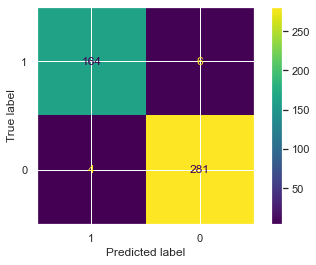

Accuracy: 0.978022
Precision: 0.976190
Recall: 0.964706
Balanced Accuracy: 0.975335
F1 Score: 0.970414


In [98]:
lasso_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'lasso')

<Figure size 1080x864 with 0 Axes>

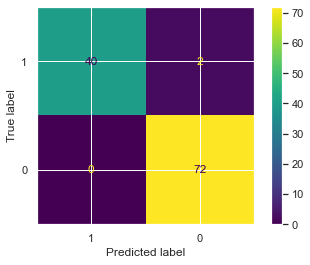

Accuracy: 0.982456
Precision: 1.000000
Recall: 0.952381
Balanced Accuracy: 0.976190
F1 Score: 0.975610


In [99]:
lasso_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'lasso')

In [117]:
# Obtain Cross-Validation score
print("Test F1 score is:", cross_val_score(lasso_model, X_test, y_test, cv=10, scoring='f1').mean())
print("Test recall is:", cross_val_score(lasso_model, X_test, y_test, cv=10, scoring='recall').mean())
print("Test precision is:", cross_val_score(lasso_model, X_test, y_test, cv=10, scoring='precision').mean())

Test F1 score is: 0.9709090909090909
Test recall is: 1.0
Test precision is: 0.95


As we can see our baseline model, our lasso model provides very good results. Lets also try out some different models using the selected features. We will train: Random Forest and MLP.

In [120]:
all_results = pd.DataFrame()
results = pd.DataFrame(data=lasso_test_metrics).set_index('model')
all_results.drop(['baseline'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

acc  prec    recall  bal_acc       f1
model                                            
lasso  0.982456   1.0  0.952381  0.97619  0.97561

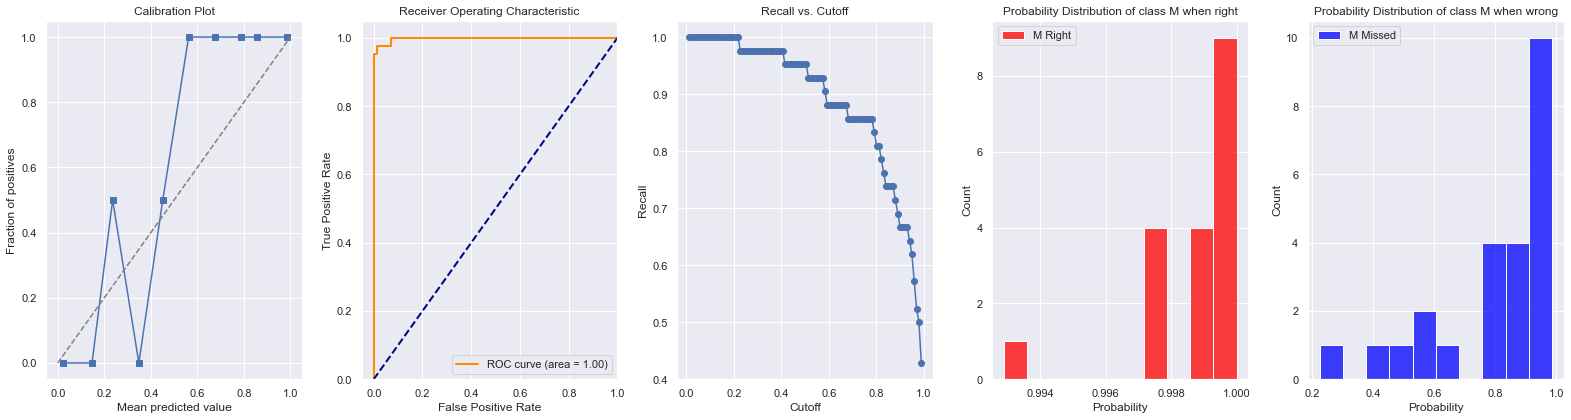

In [121]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

### Random Forest 

RandomForest Trained
Best params:
 {'RF__max_depth': 7, 'RF__min_samples_split': 2, 'RF__n_estimators': 78}


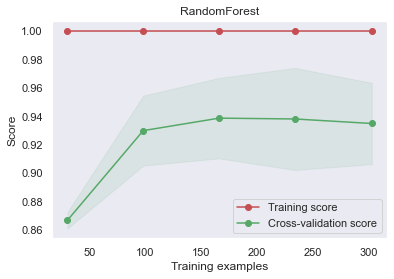

In [136]:
param = {
    'RF__min_samples_split': np.arange(2,4), 
    'RF__n_estimators': np.arange(70, 80, 2),
    'RF__max_depth': np.arange(6,8) 
}

pipe = Pipeline(steps=[('scaler',StandardScaler()),
                       ('RF', RandomForestClassifier(random_state=42,
                                                     criterion='entropy',
                                                     bootstrap='true'))]) 

rf_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'RandomForest', cv=3, learning=True, X_tr=X_train_selected, X_te=X_test_selected)
random_forest_model = rf_fit.best_estimator_.named_steps['RF']

<Figure size 1080x864 with 0 Axes>

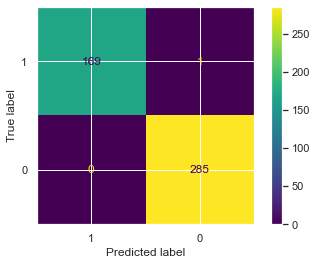

Accuracy: 0.997802
Precision: 1.000000
Recall: 0.994118
Balanced Accuracy: 0.997059
F1 Score: 0.997050


<Figure size 1080x864 with 0 Axes>

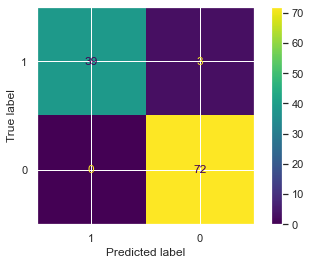

Accuracy: 0.973684
Precision: 1.000000
Recall: 0.928571
Balanced Accuracy: 0.964286
F1 Score: 0.962963


In [137]:
rf_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'RandomForest')
rf_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'RandomForest')

In [157]:
results = pd.DataFrame(data=rf_test_metrics).set_index('model')
all_results.drop(['RandomForest'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

acc  prec    recall   bal_acc        f1
model                                                     
lasso         0.982456   1.0  0.952381  0.976190  0.975610
RandomForest  0.973684   1.0  0.928571  0.964286  0.962963

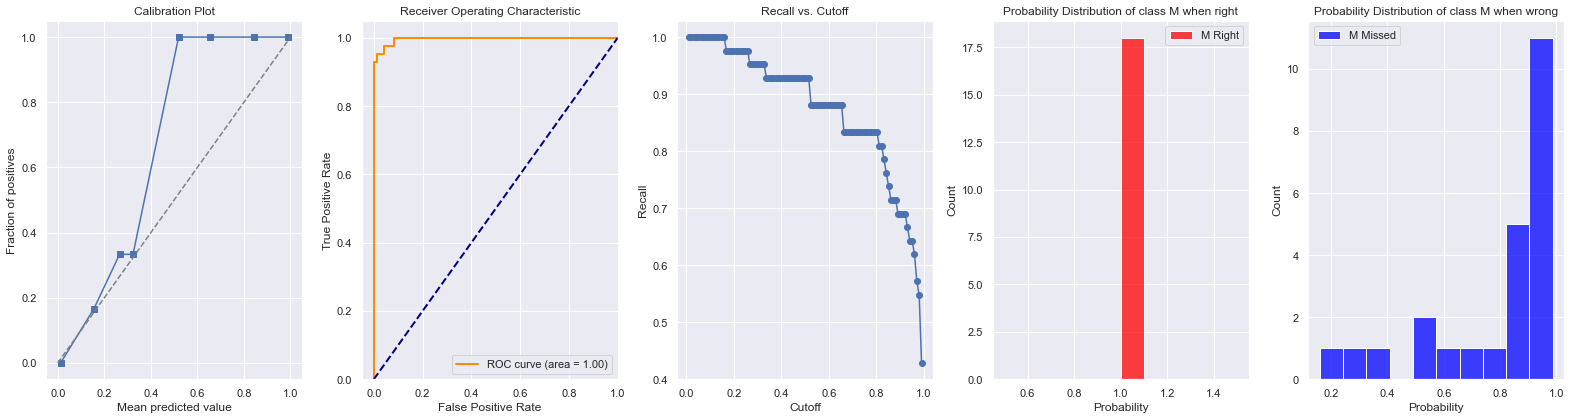

In [139]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

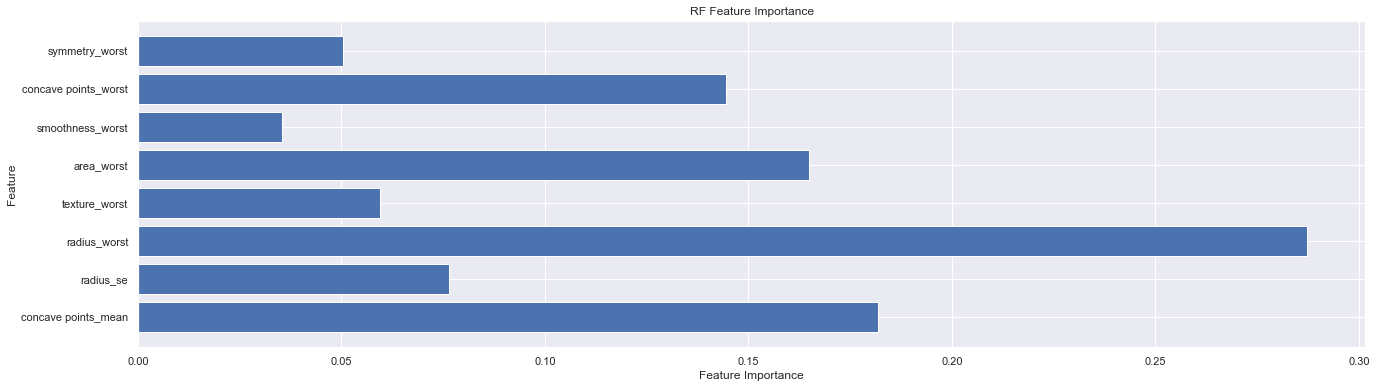

In [153]:
# Obtain feature importances from the trained model
importances_rf = random_forest_model.feature_importances_

# Plot feature importances
fig = plt.figure(2, figsize=(22, 6)) 
plt.barh(selected_features.get_feature_names_out(input_features=X_train.columns), importances_rf)
plt.grid()
plt.title('RF Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.grid()
plt.show()

### MLP

MLP Trained
Best params:
 {'MLP__alpha': 0.2, 'MLP__hidden_layer_sizes': (10,)}


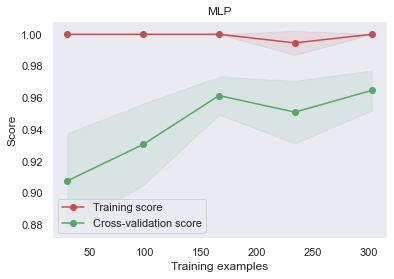

In [154]:
 # Le pasamos el dato raw a la red y dejamos que sea ella quien saque sus propias conclusiones

param = {
         'MLP__alpha': [0.01, 0.1, 0.2, 0.25, 0.3], # L2 regularization term 
         'MLP__hidden_layer_sizes':[(5,),(10,),(15,),(5,5,), (10,10,)]} # Number of neurons in each hidden layer, enters as tuples
         

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('MLP', MLPClassifier(solver='lbfgs', # Update function
                                             activation='logistic', # Logistic sigmoid activation function
                                             max_iter=450, # Maximum number of iterations
                                             tol=1e-4, # Tolerance for the optimization
                                             random_state=42))]) # For replication

model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'MLP', cv=3, learning=True)                                             

<Figure size 1080x864 with 0 Axes>

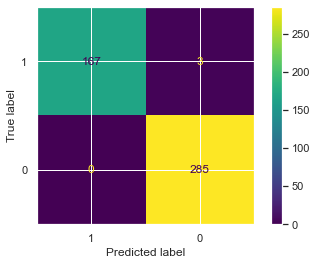

Accuracy: 0.993407
Precision: 1.000000
Recall: 0.982353
Balanced Accuracy: 0.991176
F1 Score: 0.991098


<Figure size 1080x864 with 0 Axes>

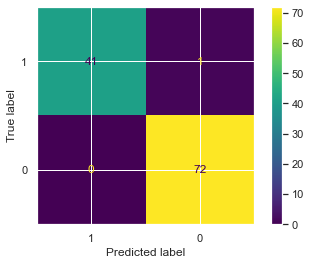

Accuracy: 0.991228
Precision: 1.000000
Recall: 0.976190
Balanced Accuracy: 0.988095
F1 Score: 0.987952


In [155]:
MLP_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'MLP')
MLP_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'MLP')

In [158]:
results = pd.DataFrame(data=MLP_test_metrics).set_index('model')
all_results.drop(['MLP'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

acc  prec    recall   bal_acc        f1
model                                                     
lasso         0.982456   1.0  0.952381  0.976190  0.975610
RandomForest  0.973684   1.0  0.928571  0.964286  0.962963
MLP           0.991228   1.0  0.976190  0.988095  0.987952

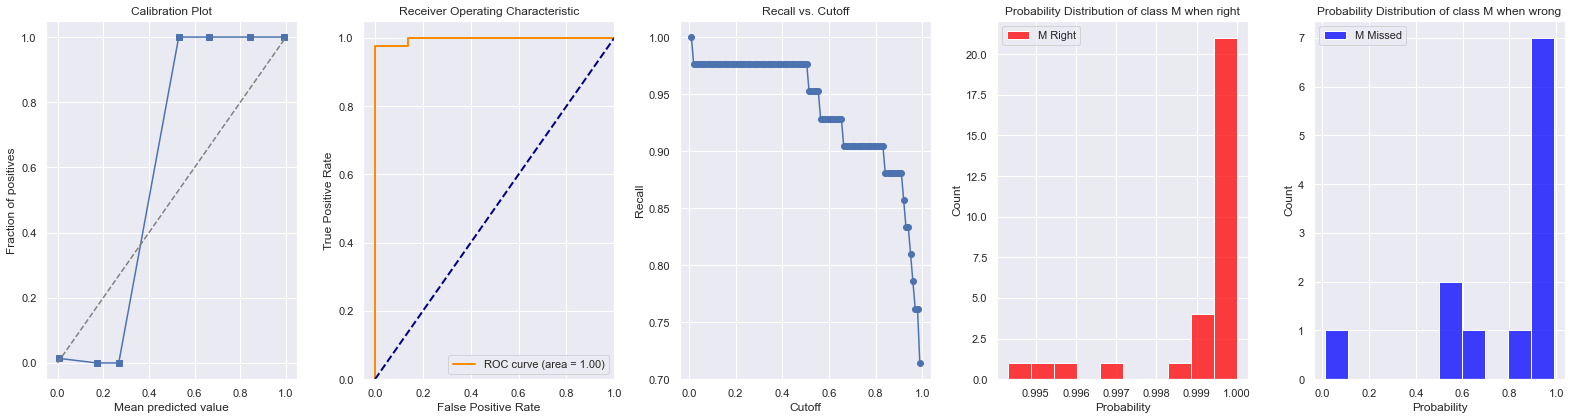

In [159]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

## Conclusions

The best result was obtained by the MLP, feeding the data without feature selection, allowing the neural network to draw its own conclussions. L1 Logistic Regression achieved results almost as good as MLP. While the MLP achieves the highest F1 score, I would stick with logistic regression for its simplicity and explainability which might come in handy if required to provide explanation to professionals not specialized in this field, however, again if we were to just go for results, MLP would then be the choice. RF while being the worst model out of the three provides an insight into feature importance.

<b>Model of Choice:</b> L1 Logistic Regression

In [163]:
# Sort all values of a df based on their column f1

all_results.sort_values(by='f1', ascending=False)

acc  prec    recall   bal_acc        f1
model                                                     
MLP           0.991228   1.0  0.976190  0.988095  0.987952
lasso         0.982456   1.0  0.952381  0.976190  0.975610
RandomForest  0.973684   1.0  0.928571  0.964286  0.962963

## Deployment

In [165]:
final_model = lasso_model.named_steps['logisticregression']
model_path = os.path.join(os.getcwd(), '../devops/lasso_fit.joblib')
dump(final_model, model_path) 

['d:\\ALEJANDRO\\personalProjects\\DataScientist\\Classification\\Wisconsin-Breast-Cancer\\notebooks\\../devops/lasso_fit.joblib']